[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dirga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dirga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


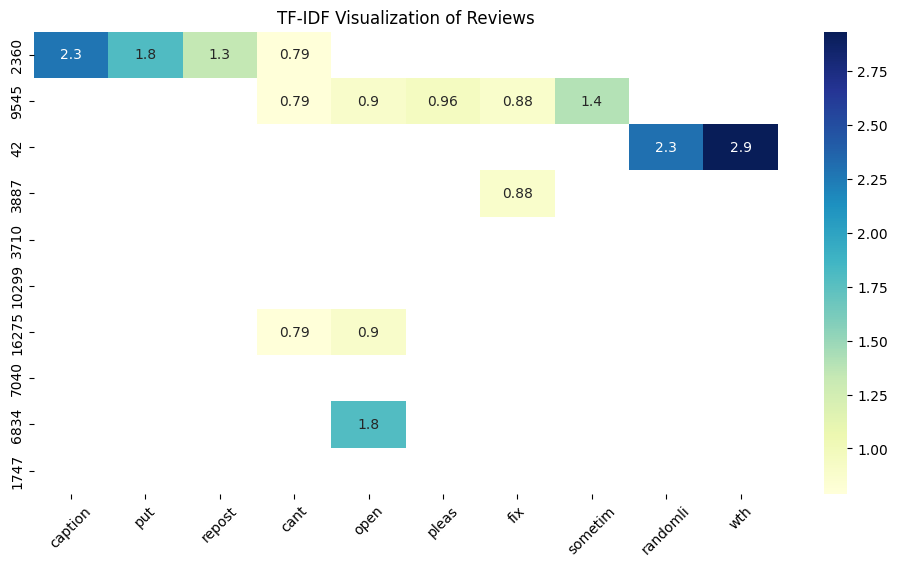

In [4]:
# %% [markdown]
# # Import Data

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from typing import List
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK resources (jika belum diunduh)
nltk.download("punkt")
nltk.download("stopwords")

# %%
# 1. Baca data CSV
df = pd.read_csv("scrapped_Tiktok_EN.csv")  # Ganti dengan path file aslimu

# %%
df = df.dropna(subset=["content"])  # Hapus baris dengan content kosong
reviews = df["content"].astype(str)  # Konversi ke string

# %%
df["at"] = pd.to_datetime(df["at"])  # Ubah ke format tanggal
df_filtered = df[df["at"].dt.year == 2024]

df_filtered.shape

# %%
df = df_filtered.sample(n=6000, random_state=42)  # Ambil 6000 data 
df.score.value_counts()

# %% [markdown]
# ## Tokenizing, Stopword Removal, dan Stemming

# %%
# Inisialisasi stemmer dan daftar stopwords bahasa Inggris
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))  # Menggunakan set agar pencarian lebih cepat

def preprocess_text(text: str) -> List[str]:
    """Membersihkan teks, tokenize, hapus stopwords, dan lakukan stemming."""
    text = re.sub(r"[^\w\s]", "", text)  # Hapus tanda baca
    tokens = word_tokenize(text.lower())  # Tokenisasi & ubah ke lowercase
    filtered_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]  # Stopword removal + stemming
    return filtered_tokens

# Terapkan preprocessing
df["tokens"] = df["content"].apply(preprocess_text)
df[["content", "tokens"]].head()  # Cek hasil preprocessing

# %%
# Buat total corpus (daftar kata unik di seluruh dataset)
total_corpus = set(word for tokens in df["tokens"] for word in tokens)

word_count_list = []
for tokens in df["tokens"]:
    word_count = dict.fromkeys(total_corpus, 0)
    for word in tokens:
        word_count[word] += 1
    word_count_list.append(word_count)

# %% [markdown]
# ## Hitung TF

# %%
def compute_tf(tokens):
    """Menghitung Term Frequency (TF)"""
    word_counts = {word: 0 for word in tokens}
    for word in tokens:
        word_counts[word] += 1  # Hitung jumlah kemunculan kata
    
    total_words = len(tokens)  # Total kata dalam dokumen
    tf_dict = {word: count / total_words for word, count in word_counts.items()}  # Rumus TF
    return tf_dict

df["tf"] = df["tokens"].apply(compute_tf)  # Hitung TF untuk setiap review
df[["content", "tf"]].head()

# %% [markdown]
# ## Hitung IDF

# %%
def idf(word_counts):
    """Menghitung Inverse Document Frequency (IDF)"""
    N = len(word_counts)
    idf_dict = dict.fromkeys(word_counts[0].keys(), 0)

    for word in idf_dict.keys():
        idf_dict[word] = sum(1 for doc in word_counts if doc[word] > 0)

    for word, df in idf_dict.items():
        idf_dict[word] = np.log10((N + 1) / (df + 1))  # Rumus IDF

    return idf_dict

idfs = idf(word_count_list)

# %%
idfs

# %% [markdown]
# ## Hitung TF-IDF dan Terapkan Threshold

# %%
def tfidf(word_counts, idfs, threshold=0.01):
    """Menghitung TF-IDF dan hanya menyimpan kata di atas threshold"""
    tfidf_list = []
    for doc in word_counts:
        tfidf_dict = {word: doc[word] * idfs[word] for word in doc}
        # Terapkan threshold: hanya simpan kata yang memiliki TF-IDF di atas ambang batas
        filtered_tfidf = {word: score for word, score in tfidf_dict.items() if score >= threshold}
        tfidf_list.append(filtered_tfidf)
    return tfidf_list

# Hitung TF-IDF dengan threshold
tfidf_values = tfidf(word_count_list, idfs, threshold=0.01)

# %% [markdown]
# ## Konversi ke DataFrame

# %%
# Konversi hasil TF-IDF ke DataFrame
tfidf_df = pd.DataFrame(tfidf_values, index=df.index)
tfidf_df.head()

# %%
tfidf_df.describe()

# %%
tfidf_df.sum(axis=1).sort_values(ascending=False).head(10)

# %% [markdown]
# ## Visualisasi Hasil TF-IDF

# %%
plt.figure(figsize=(12, 6))
sns.heatmap(tfidf_df.iloc[:10, :10], cmap="YlGnBu", annot=True)
plt.xticks(rotation=45)
plt.title("TF-IDF Visualization of Reviews")
plt.show()


In [5]:
tfidf_df.head()

,caption,put,repost,cant,open,pleas,fix,sometim,randomli,wth,...,commis,afflieat,shoptiktok,thailand,grrrrrrr,ehat,lala,fixbut,tiktol,loll
2360,2.273074,1.795952,1.335744,0.790111,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9545,NaN,NaN,NaN,0.790111,0.89513,0.956056,0.882801,1.394408,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.301102,2.933126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3887,NaN,NaN,NaN,NaN,NaN,NaN,0.882801,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
tfidf_df.describe()

,caption,put,repost,cant,open,pleas,fix,sometim,randomli,wth,...,commis,afflieat,shoptiktok,thailand,grrrrrrr,ehat,lala,fixbut,tiktol,loll
count,31.000000,95.000000,276.000000,972.000000,763.000000,663.000000,785.000000,241.000000,29.000000,6.000000e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,2.419724,1.985000,1.853587,0.895784,1.145016,1.091605,0.972768,1.510127,2.380451,2.933126e+00,...,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194
std,0.567657,0.762574,1.054901,0.317316,0.510188,0.462127,0.298853,0.405941,0.427304,4.864754e-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.273074,1.795952,1.335744,0.790111,0.895130,0.956056,0.882801,1.394408,2.301102,2.933126e+00,...,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194
25%,2.273074,1.795952,1.335744,0.790111,0.895130,0.956056,0.882801,1.394408,2.301102,2.933126e+00,...,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194
50%,2.273074,1.795952,1.335744,0.790111,0.895130,0.956056,0.882801,1.394408,2.301102,2.933126e+00,...,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194
75%,2.273074,1.795952,2.671488,0.790111,0.895130,0.956056,0.882801,1.394408,2.301102,2.933126e+00,...,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194
max,4.546147,7.183810,6.678719,3.950554,4.475651,6.692389,3.531204,4.183225,4.602205,2.933126e+00,...,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194,3.477194
